In [108]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family':'Times New Roman', 
    'font.size': 14,  # 字体大小
    'axes.titlesize': 16,  # 轴标题的字体大小
    'axes.labelsize': 14,  # 轴标签的字体大小
    'xtick.labelsize': 12,  # x轴刻度的字体大小
    'ytick.labelsize': 12,  # y轴刻度的字体大小
    'legend.fontsize': 14,  # 图例的字体大小
})

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split 

# 1.Input

In [109]:
step = 72
dataset = np.load(f'dataset/dataset_{step}.npy')

In [110]:
train , test = train_test_split(
    dataset, random_state = 12, 
    shuffle=True,test_size =0.2
    )

test , validate = train_test_split(
    test, 
    random_state = 72, 
    shuffle=True, 
    test_size =0.5
    )

train.shape, validate.shape, test.shape

((1092, 288), (137, 288), (136, 288))

# 2.DataLoader

In [111]:
def get_loader(data, batch_size):
    tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(-1).permute(0, 2, 1)
    dataset = TensorDataset(tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [112]:
batch_size = 16

train_loader = get_loader(train, batch_size)
valid_loader = get_loader(validate, batch_size)

In [113]:
for data in valid_loader:
    print(data[0].shape)
    break

torch.Size([16, 1, 288])


In [114]:
train[0]

array([0.65186766, 0.65485592, 0.65688367, 0.660619  , 0.66446105,
       0.65752401, 0.61430096, 0.61344717, 0.61622199, 0.62198506,
       0.63287086, 0.64151547, 0.64845251, 0.660619  , 0.67769477,
       0.68879402, 0.7094984 , 0.73906083, 0.54770544, 0.05869797,
       0.12828175, 0.17310566, 0.19914621, 0.21366062, 0.22838847,
       0.28121665, 0.31227321, 0.32337247, 0.32614728, 0.34364995,
       0.36157951, 0.37780149, 0.39018143, 0.40448239, 0.41366062,
       0.42732124, 0.43500534, 0.44823906, 0.45731057, 0.46883671,
       0.47897545, 0.48900747, 0.49946638, 0.5090715 , 0.51792956,
       0.52934899, 0.53703308, 0.54535752, 0.55389541, 0.56542156,
       0.58110993, 0.59925293, 0.63180363, 0.68676628, 0.76350053,
       0.33532551, 0.10779082, 0.21056564, 0.2565635 , 0.27801494,
       0.29348986, 0.31141942, 0.32678762, 0.34578442, 0.36104589,
       0.3773746 , 0.39114194, 0.40533618, 0.41451441, 0.42305229,
       0.43244397, 0.43948773, 0.45144077, 0.4909285 , 0.31910

# 3.CNN-AE

In [115]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [116]:
# class ConvolutionalAutoencoder(nn.Module):
#     def __init__(self):
#         super(ConvolutionalAutoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv1d(1, 32, kernel_size=7, stride=2, padding=3),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Conv1d(32, 16, kernel_size=7, stride=2, padding=3),
#             nn.ReLU(),
#             nn.Conv1d(16, 4, kernel_size=1, stride=1, padding=0),
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose1d(4, 16, kernel_size=7, stride=2, padding=3, output_padding=1),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.ConvTranspose1d(16, 32, kernel_size=7, stride=2, padding=3, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose1d(32, 1, kernel_size=7, padding=3),
#         )
    
#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [117]:
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, stride=1, padding=3), nn.ReLU(),

            nn.MaxPool1d(kernel_size=2, stride=2), nn.ReLU(),
            nn.Dropout(0.1),

            nn.Conv1d(16, 32, kernel_size=7, stride=1, padding=3), nn.ReLU(),

            nn.MaxPool1d(kernel_size=2, stride=2), nn.ReLU(),
            nn.Dropout(0.1),

            nn.Conv1d(32, 1, kernel_size=1, stride=1, padding=0),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, 32, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),

            nn.ConvTranspose1d(32, 32, kernel_size=2, stride=2, padding=0),  # 上采样
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.ConvTranspose1d(32, 16, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),

            nn.ConvTranspose1d(16, 16, kernel_size=2, stride=2, padding=0),  # 上采样
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.ConvTranspose1d(16, 1, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 4.Train

In [118]:
# Create the model
model = ConvolutionalAutoencoder().to(device)

# Print the model
print(model)

ConvolutionalAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.1, inplace=False)
    (10): Conv1d(32, 1, kernel_size=(1,), stride=(1,))
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(1, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): ConvTranspose1d(32, 32, kernel_size=(2,), stride=(2,))
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): ConvTranspose1d(32, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (6): ReLU()
    (7): ConvTranspose1d(16, 16, kernel_size=(2,), stride=(2,))
    (8): ReLU()
    (9): Dropout(p=0.1, inplace=False)
    (10

In [119]:
# Optimizer and loss function
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

def train(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0
    for batch, data in enumerate(dataloader):
        data = data[0].to(device)
        
        # Compute prediction error
        pred = model(data)
        loss = loss_fn(pred, data)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    train_loss /= len(dataloader)
    return train_loss

def valid(dataloader, model, loss_fn):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in dataloader:
            data = data[0].to(device)
            pred = model(data)
            loss = loss_fn(pred, data)
            val_loss += loss.item()
    val_loss /= len(valid_loader)
    return val_loss

epochs = 500

patience = 10
best_loss = None
patience_counter = 0
train_loss_list = []
valid_loss_list = []
for epoch in range(epochs):
    train_loss = train(train_loader, model, loss_fn, optimizer)
    valid_loss = valid(valid_loader, model, loss_fn)

    print(f'Epoch {epoch+1}, Val Loss: {valid_loss:.4f}')
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    # early stop
    if best_loss is None or valid_loss < best_loss:
        best_loss = valid_loss
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Epoch {epoch+1}, Val Loss: {valid_loss:.4f}')
            break
print("Done!")

Epoch 1, Val Loss: 0.0377
Epoch 1, Train Loss: 0.2237
Epoch 2, Val Loss: 0.0098
Epoch 2, Train Loss: 0.0288
Epoch 3, Val Loss: 0.0061
Epoch 3, Train Loss: 0.0165
Epoch 4, Val Loss: 0.0058
Epoch 4, Train Loss: 0.0131
Epoch 5, Val Loss: 0.0049
Epoch 5, Train Loss: 0.0112
Epoch 6, Val Loss: 0.0042
Epoch 6, Train Loss: 0.0098
Epoch 7, Val Loss: 0.0047
Epoch 7, Train Loss: 0.0084
Epoch 8, Val Loss: 0.0041
Epoch 8, Train Loss: 0.0078
Epoch 9, Val Loss: 0.0034
Epoch 9, Train Loss: 0.0075
Epoch 10, Val Loss: 0.0038
Epoch 10, Train Loss: 0.0071
Epoch 11, Val Loss: 0.0031
Epoch 11, Train Loss: 0.0067
Epoch 12, Val Loss: 0.0032
Epoch 12, Train Loss: 0.0064
Epoch 13, Val Loss: 0.0027
Epoch 13, Train Loss: 0.0061
Epoch 14, Val Loss: 0.0039
Epoch 14, Train Loss: 0.0057
Epoch 15, Val Loss: 0.0024
Epoch 15, Train Loss: 0.0055
Epoch 16, Val Loss: 0.0038
Epoch 16, Train Loss: 0.0053
Epoch 17, Val Loss: 0.0034
Epoch 17, Train Loss: 0.0052
Epoch 18, Val Loss: 0.0029
Epoch 18, Train Loss: 0.0049
Epoch 19, 

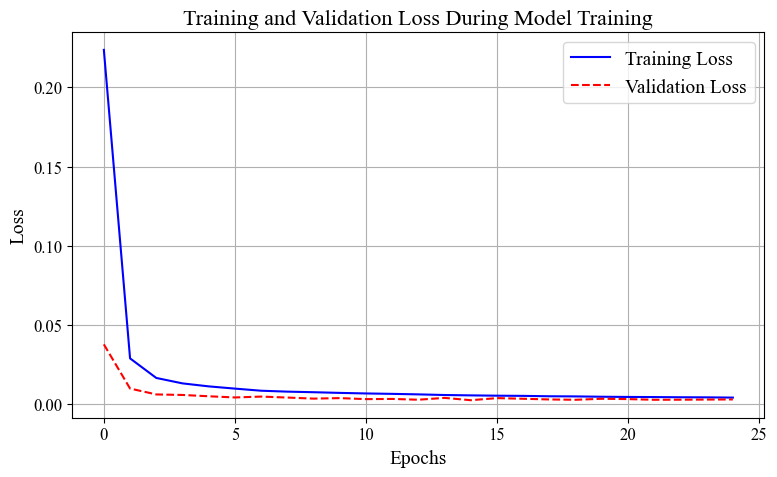

In [120]:
# 创建一个图像对象
plt.figure(figsize=(8, 5))  # 设置图像大小，适合插入到论文中

# 绘制训练损失和验证损失
plt.plot(train_loss_list, label='Training Loss', linestyle='-', color='b')
plt.plot(valid_loss_list, label='Validation Loss', linestyle='--', color='r')

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
plt.title('Training and Validation Loss During Model Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# 可选：设置网格
plt.grid(True)

# 可选：使用紧凑布局来确保图表的标签和标题都能完整显示
plt.tight_layout()

# 保存图像
plt.savefig('training_validation_loss.png', dpi=300)  # 保存为高分辨率，适合打印

# 显示图像
plt.show()

In [121]:
test_dataset = torch.tensor(test).unsqueeze(-1).permute(0, 2, 1).to(device)
model.eval()
with torch.no_grad():
    prediction = model(test_dataset.float())

pre_np = prediction.numpy().squeeze()

In [122]:
def plot_error(num, error_limit):
    ts1 = test[num]
    ts2 = pre_np[num]
    error = (ts1 - ts2)**2

    # 创建图形和子图
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # 绘制第一个子图
    axs[0].plot(ts1, label='Input')
    axs[0].plot(ts2, label='Output', linestyle='--')
    axs[0].set_title('Input and output comparison')
    
    # 标记误差超过许用误差的点
    over_tolerance = np.abs(error) > error_limit
    axs[0].scatter(np.where(over_tolerance), ts1[over_tolerance], color='red', label='Out of Tolerance (anormaly)')
    # axs[0].scatter(np.where(over_tolerance), ts2[over_tolerance], color='yellow', label='Out of Tolerance (TS2)')
    axs[0].legend(loc='upper right')

    # 绘制第二个子图
    axs[1].plot(error, color='red', label='Squared Error')
    axs[1].set_title('Reconstruction error')
    axs[1].axhline(y=error_limit, color='green', linestyle='--', label='Tolerance Threshold')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel('Squared Error')
    axs[1].legend(loc='upper right')

    # 显示整个图形
    plt.tight_layout()
    plt.show()

In [123]:
def get_tolerance(data):
    dataset = torch.tensor(data).unsqueeze(-1).permute(0, 2, 1).to(device)
    model.eval()
    with torch.no_grad():
        prediction = model(dataset.float())

    pre_np = prediction.numpy().squeeze()
    error = (data - pre_np)**2
    return error

error_limit = np.mean(get_tolerance(validate)) + np.std(get_tolerance(validate))
error_limit

0.010571765257950118

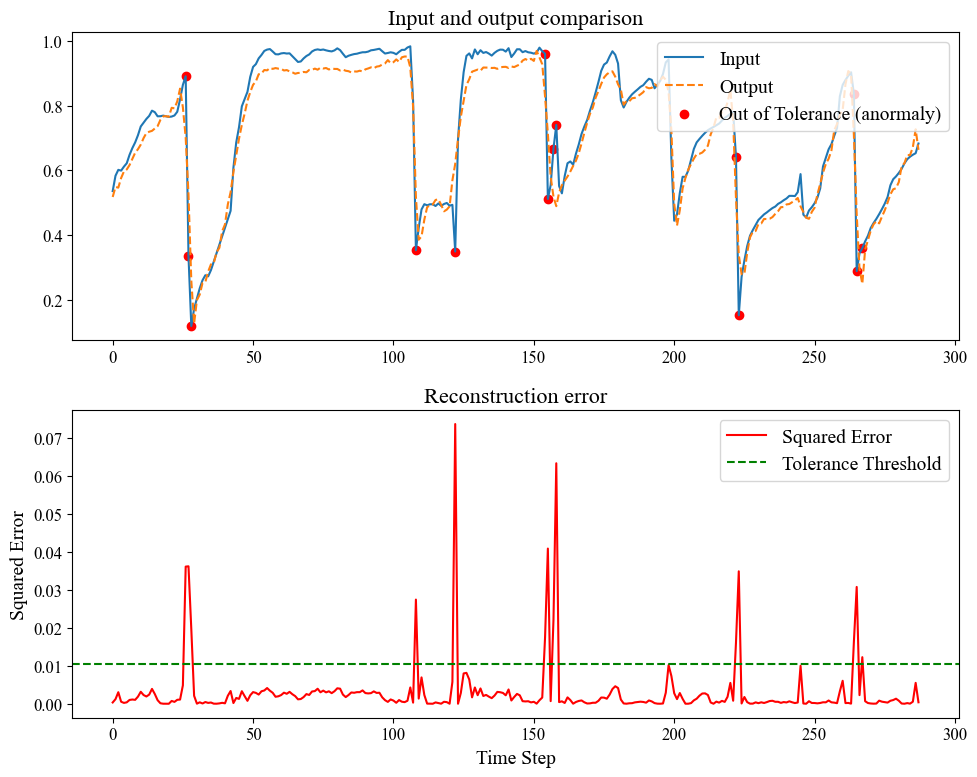

In [124]:
plot_error(12, error_limit)